In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


from timeit import default_timer
from Solver import *
from functools import partial

import torch

import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import NeuralNet
import PlotDefault



In [2]:
beta_rek_strs = [("1", "0p3"), ("2", "0p3"), ("3", "0p3"), ("1", "0p6"), ("2", "0p6"), ("3", "0p6")]


beta_reks = [ (str_to_num(beta_rek_strs[i][0]), str_to_num(beta_rek_strs[i][1])) for i in range(len(beta_rek_strs)) ]
physics_params, q_mean, psi_mean, dpv_mean,  mu_mean, mu_mean_clip,  closure_mean, yy, force = load_data(beta_rek_strs = beta_rek_strs, beta_reks = beta_reks)


Ny = 256
L = 50*2*np.pi
yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny


k2, dealiasing_filter = precomp_fft(Ny)

u_mean = np.copy(psi_mean)
for j in range(len(beta_reks)):
    for i in range(2):
        u_mean[j,i,:]  = -gradient_fft(psi_mean[j,i,:], dy, 1, k2, dealiasing_filter)
        

# Visualize data

Text(0.5, 0.98, 'bottom layer')

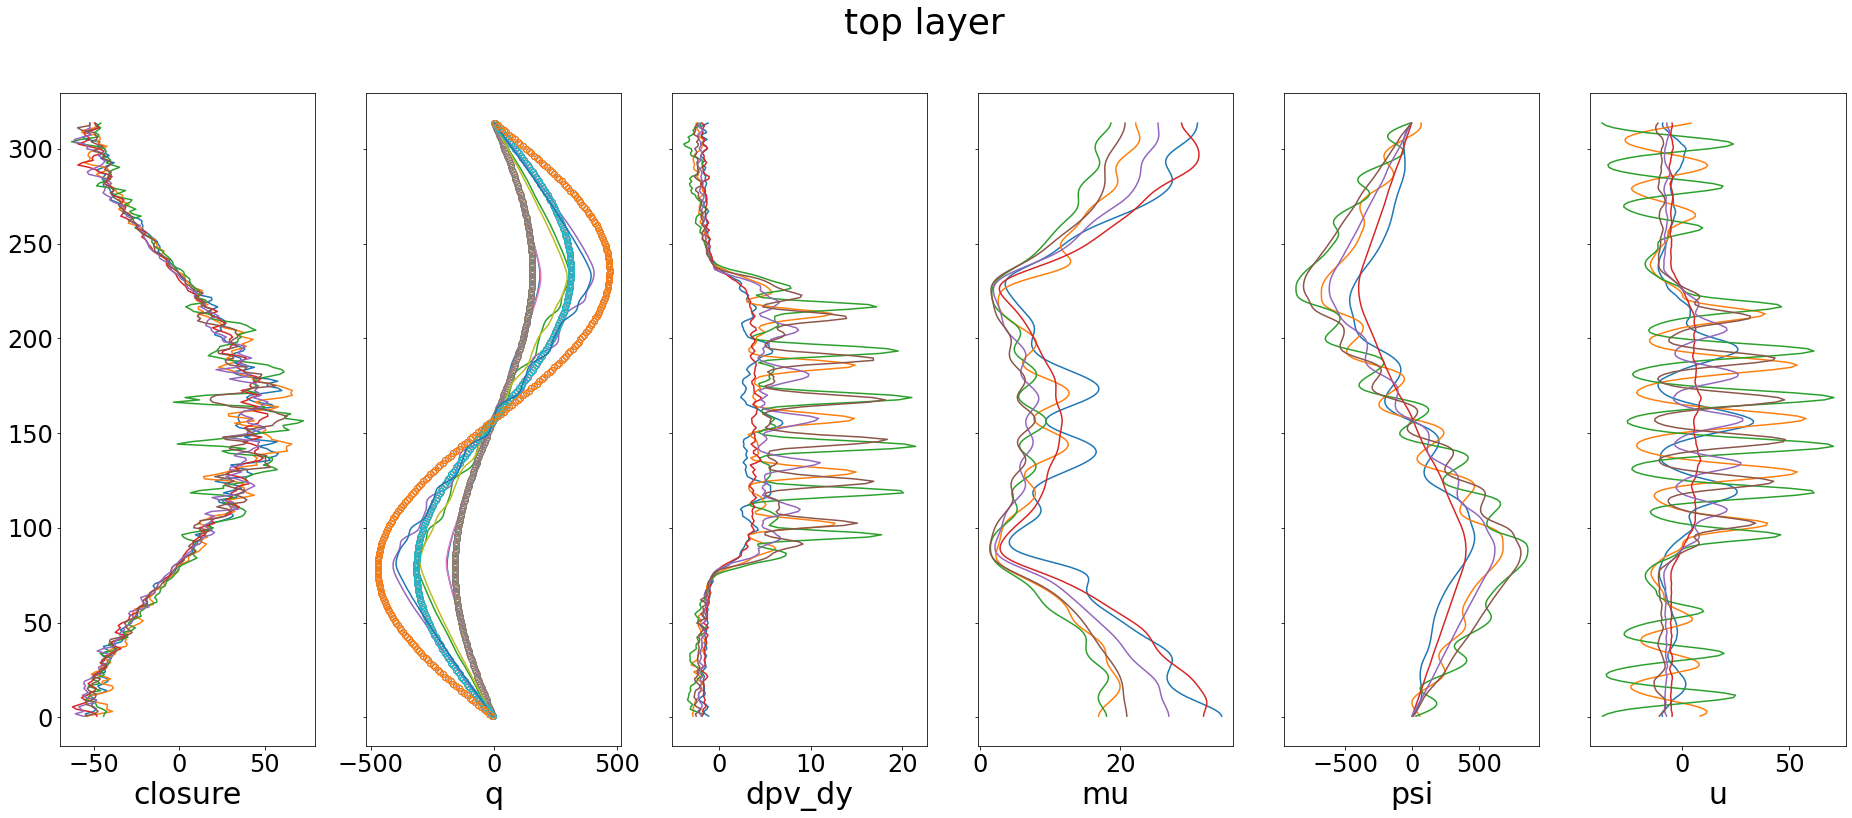

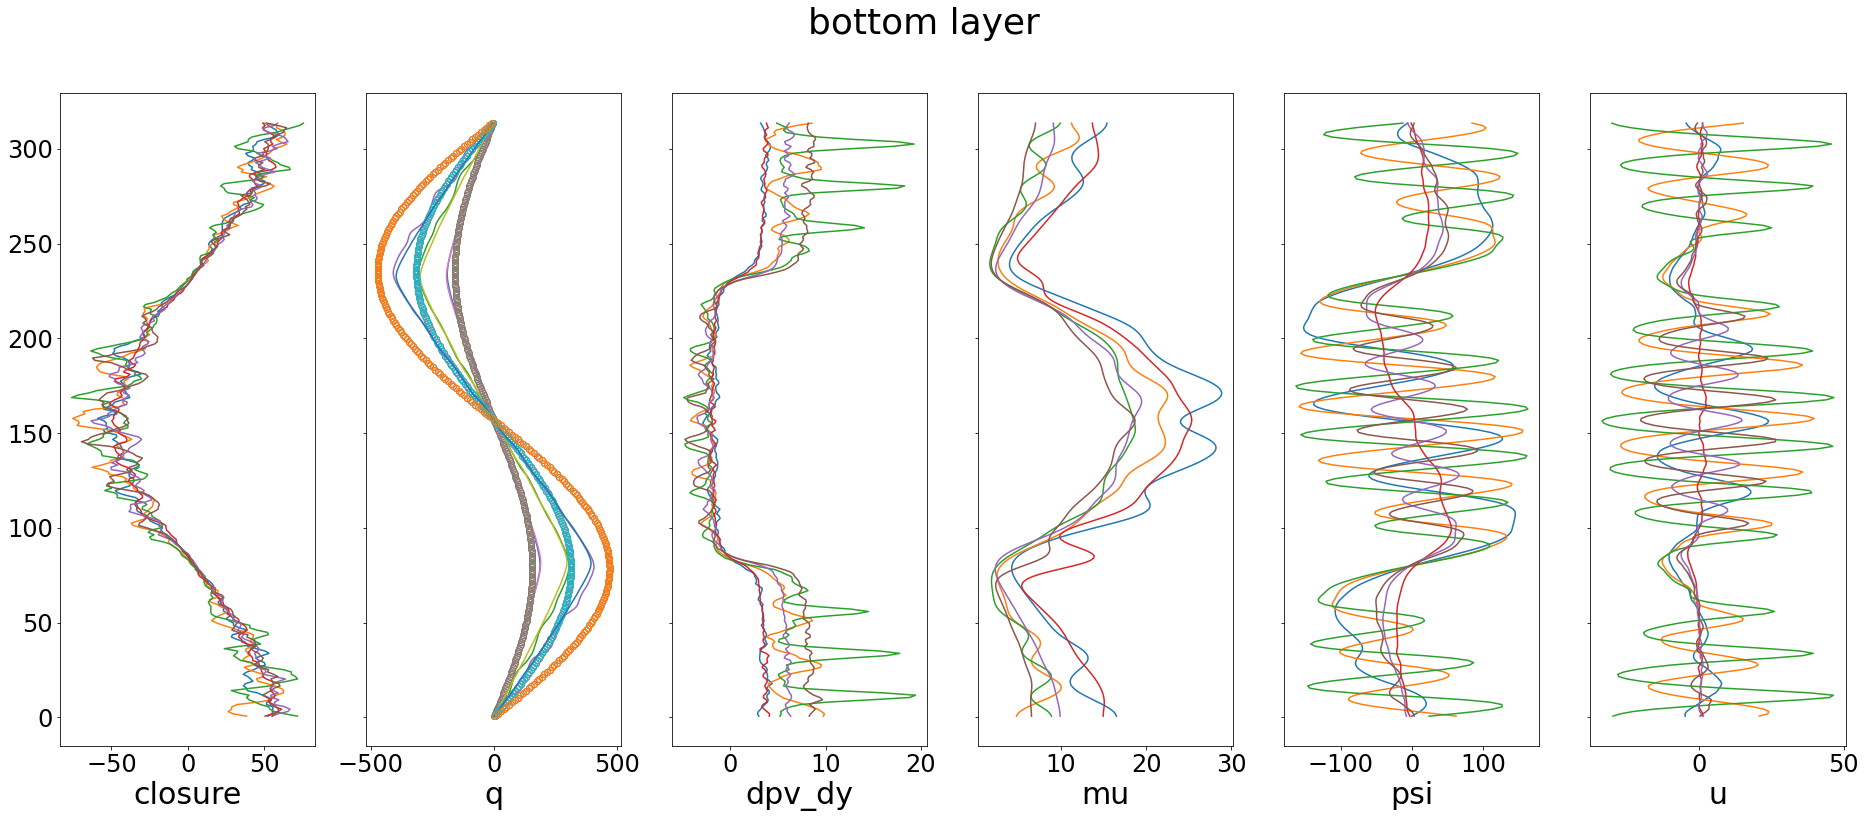

In [3]:
L = 50.0 *2*np.pi

N_data = len(beta_reks)
layer = 0
fig, ax = plt.subplots(nrows=1, ncols=6, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
    
    ax[1].plot(-beta_reks[i][0]*L/2*np.sin(2*np.pi*yy/L), yy, "o", fillstyle="none")
    
    
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean_clip[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    ax[5].plot(u_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
    ax[5].set_xlabel("u")
fig.suptitle("top layer")

layer = 1
fig, ax = plt.subplots(nrows=1, ncols=6, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
               
    ax[1].plot(beta_reks[i][0]*L/2*np.sin(2*np.pi*yy/L), yy, "o", fillstyle="none")
                          
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean_clip[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    ax[5].plot(u_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
    ax[5].set_xlabel("u")
fig.suptitle("bottom layer")

# scatter training points

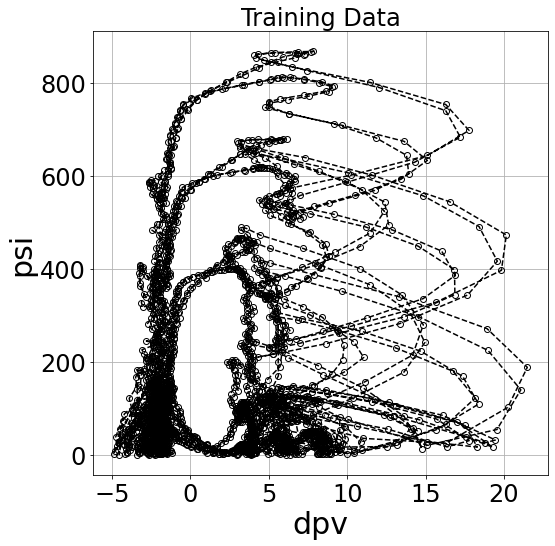

In [4]:
plt.figure(figsize=(8,8))
for i in range(N_data):
#     plt.plot(np.fabs(q_mean[i,0,:]), dpv_mean[i, 0, :],  "--o", color = "black", fillstyle="none")
#     plt.plot(np.fabs(q_mean[i,1,:]), dpv_mean[i, 1, :],  "--o", color = "black", fillstyle="none")
    plt.plot(dpv_mean[i, 0, :], np.fabs(psi_mean[i,0,:]),   "--o", color = "black", fillstyle="none")
    plt.plot(dpv_mean[i, 1, :], np.fabs(psi_mean[i,1,:]),  "--o", color = "black", fillstyle="none")
    
plt.grid("on")
plt.xlabel("dpv")
plt.ylabel("psi")
plt.title("Training Data")

    
plt.subplots_adjust(bottom=0.15,top=0.92,left=0.18,right=0.97)
plt.savefig("QG-Training-Data.pdf")

In [5]:
import itertools

# polynomial orders in nps, nps[0] = 0
def generate_feature(nps, *arg):
    assert(nps[0] == 0)
    
    nf = len(arg)
    nd = len(arg[0])
    
    # generate powers
    powers = list(itertools.product(nps, repeat=nf))
    
    dic = []
    for indp in range(len(powers)):
        cpower = powers[indp]
        if all(p == 0 for p in cpower):
            continue
            
        feature = np.ones(nd)
        for i in range(nf):
            feature *= arg[i]**cpower[i]
        dic.append(feature)
    
    
    return np.vstack(dic).T

nps = [0,1,2,3]

In [6]:
layers = 1
outputlayer = "None"

In [7]:
from torch.optim import LBFGS
# scale input 
for nn_save_name in ["diffusivity.linear.dic", "flux.linear.dic"]:
    ## generate_feature
    x_train = generate_feature(nps, np.fabs(q_mean).flatten()/q_scale, dpv_mean.flatten()/dpv_scale, np.fabs(psi_mean).flatten()/psi_scale, u_mean.flatten()/u_scale)
    x_train = torch.from_numpy(x_train.astype(np.float32))
    if nn_save_name == "diffusivity.linear.dic":
        outputlayer = "None"
        y_train = (torch.from_numpy(mu_mean_clip.flatten()[:,np.newaxis].astype(np.float32)) - mu_low) / mu_scale
    elif nn_save_name == "flux.linear.dic":
        outputlayer = "None"
        y_train = torch.from_numpy(closure_mean.flatten()[:,np.newaxis].astype(np.float32)) / flux_scale
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
    
    ind = x_train.shape[1]
    outd = y_train.shape[1] 

    learning_rate = 0.001
    step_size = 100
    gamma = 0.5  
    epochs = 20000
    batch_size = 100000


    net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False)

#     optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
 
    optimizer = LBFGS(net.parameters(), history_size=10, max_iter=4)



    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss(reduction='sum')
    t0 = default_timer()
    for ep in range(epochs):
        net.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            
            def closure():
                optimizer.zero_grad()
                out = net(x)

                loss = myloss(out , y)*100
                loss.backward()
                return loss

            optimizer.step(closure)
            loss = closure()
            train_l2 += loss.item()

    #     scheduler.step()

        if ep % 100 == 0:
            # train_l2/= ntrain
            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
            if nn_save_name is not None:
                torch.save(net, nn_save_name)



Epoch :  0  Epoch time :  0.027794732712209225  Train L2 Loss :  249641952.0
Epoch :  100  Epoch time :  0.02720404975116253  Train L2 Loss :  69826.5078125
Epoch :  200  Epoch time :  0.026570262387394905  Train L2 Loss :  30953.58984375
Epoch :  300  Epoch time :  0.025858991779386997  Train L2 Loss :  16002.2783203125
Epoch :  400  Epoch time :  0.025689683854579926  Train L2 Loss :  10685.3837890625
Epoch :  500  Epoch time :  0.08643287234008312  Train L2 Loss :  9441.00390625
Epoch :  600  Epoch time :  0.027356996200978756  Train L2 Loss :  8222.7607421875
Epoch :  700  Epoch time :  0.025680147111415863  Train L2 Loss :  6241.8173828125
Epoch :  800  Epoch time :  0.025199126452207565  Train L2 Loss :  4493.95263671875
Epoch :  900  Epoch time :  0.025010982528328896  Train L2 Loss :  3556.916015625
Epoch :  1000  Epoch time :  0.026691756211221218  Train L2 Loss :  3188.06005859375
Epoch :  1100  Epoch time :  0.026817413978278637  Train L2 Loss :  2848.2392578125
Epoch :  120

# Direct test

../Utility/NeuralNet.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()
../Utility/NeuralNet.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()


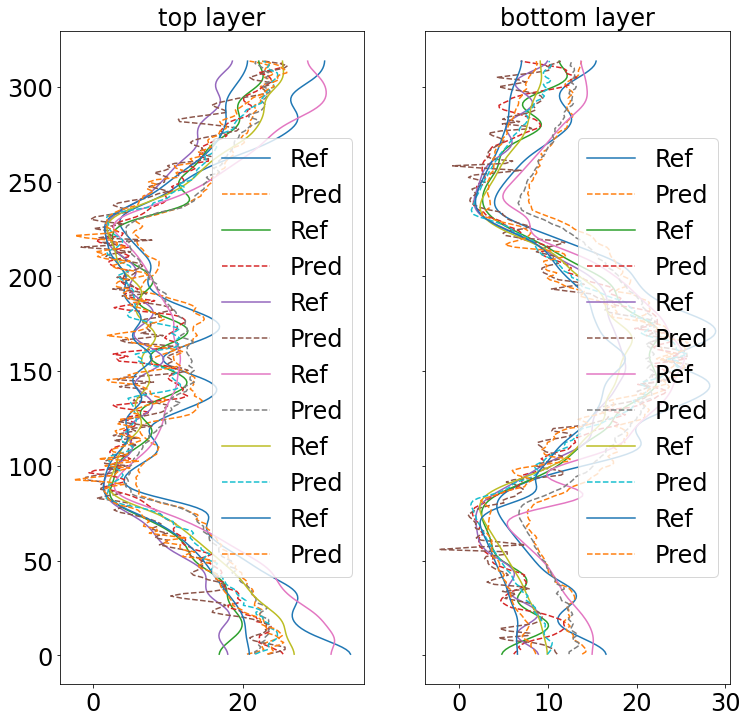

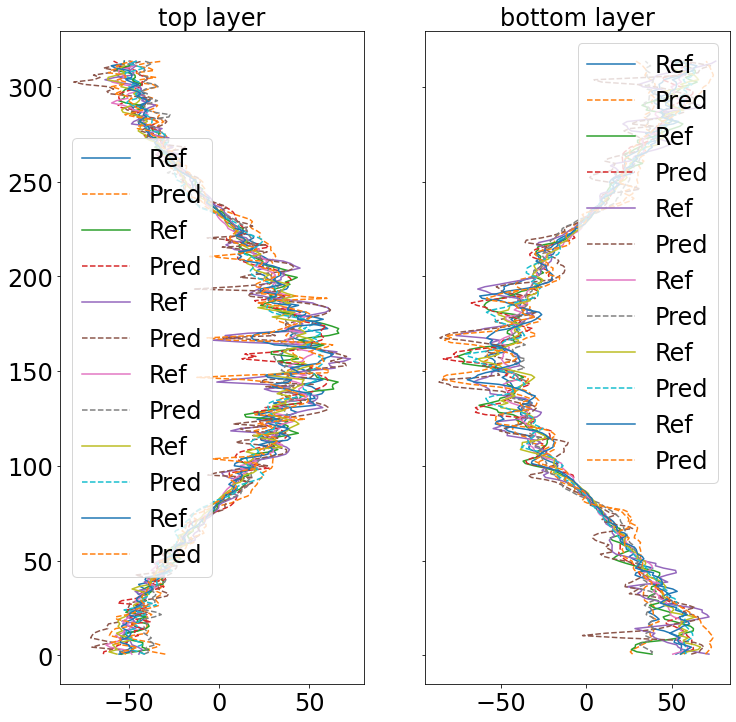

In [7]:
L = 50.0 *2*np.pi

N_data = len(beta_reks)
layer = 0

for nn_save_name in ["diffusivity.linear.dic", "flux.linear.dic"]:
    trained_net = torch.load(nn_save_name)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(12,12))
    x_train = generate_feature(nps, np.fabs(q_mean).flatten()/q_scale, dpv_mean.flatten()/dpv_scale, np.fabs(psi_mean).flatten()/psi_scale, u_mean.flatten()/u_scale)
    x_train = torch.from_numpy(x_train.astype(np.float32))
    
    if nn_save_name == "diffusivity.linear.dic":
        outputlayer = "None"
        y_pred = NeuralNet.net_eval(net=trained_net, x=x_train, mu_scale=mu_scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma, n_data=2*N_data) + mu_low 
        y_pred = y_pred.reshape((N_data, 2, len(yy)))
        for i in range(N_data):
            ax[0].plot(mu_mean_clip[i,0, :], yy, label="Ref")
            ax[1].plot(mu_mean_clip[i,1, :], yy, label="Ref")
            ax[0].plot(y_pred[i,0, :], yy, "--", label="Pred")
            ax[1].plot(y_pred[i,1, :], yy, "--",label="Pred")
        
            
    elif nn_save_name == "flux.linear.dic":
        outputlayer = "None"
        y_pred = NeuralNet.net_eval(net=trained_net, x=x_train, mu_scale=flux_scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma, n_data=2*N_data) 
        y_pred = y_pred.reshape((N_data, 2, len(yy)))
        for i in range(N_data):
            ax[0].plot(closure_mean[i,0, :], yy, label="Ref")
            ax[1].plot(closure_mean[i,1, :], yy, label="Ref")
            ax[0].plot(y_pred[i,0, :], yy, "--", label="Pred")
            ax[1].plot(y_pred[i,1, :], yy, "--", label="Pred")
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
    ax[0].legend()
    ax[0].set_title("top layer")
    ax[1].legend()
    ax[1].set_title("bottom layer")
  

In [8]:
def nummodel_fft(permeability, beta1, beta2, q, psi, yy, res, k2, dealiasing_filter):
    
    dy = yy[1] - yy[0]
    
    # all are at the cell center
    
    dq1, dq2 = gradient_fft(q[0, :], dy, 1, k2, dealiasing_filter), gradient_fft(q[1, :], dy, 1, k2, dealiasing_filter)
    dpv = np.hstack((dq1 + beta1,dq2 + beta2))   
    
    u_mean = np.copy(psi)
    for i in range(2):
        u_mean[i,:]  = -gradient_fft(psi[i,:], dy, 1, k2, dealiasing_filter)

#     x = np.vstack((np.fabs(q).flatten()/q_scale, dpv/dpv_scale, np.fabs(psi).flatten()/psi_scale)).T
    x = generate_feature(nps, np.fabs(q).flatten()/q_scale, dpv/dpv_scale, np.fabs(psi).flatten()/psi_scale, u_mean.flatten()/u_scale)
    # x = np.vstack((dpv, np.fabs(psi).flatten()/psi_scale)).T
    
    # x = dpv.reshape((-1, 1))
    
    mu = permeability(x = x)  + mu_low 
    
    mu[mu > mu_scale] = mu_scale
    
    
    mu_c1 = mu[0: len(yy)]
    mu_c2 = mu[len(yy):]
    
    
    
    res[0, :] = gradient_fft(mu_c1 * (dq1 + beta1), dy, 1, k2, dealiasing_filter)
    res[1, :] = gradient_fft(mu_c2 * (dq2 + beta2), dy, 1, k2, dealiasing_filter)

    
    
def nummodel_flux_fft(flux_model, beta1, beta2, q, psi, yy, res, k2, dealiasing_filter):
    
    dy = yy[1] - yy[0]
    
    # all are at the cell center
    
    dq1, dq2 = gradient_fft(q[0, :], dy, 1, k2, dealiasing_filter), gradient_fft(q[1, :], dy, 1, k2, dealiasing_filter)
    dpv = np.hstack((dq1 + beta1, dq2 + beta2))   
    
    u_mean = np.copy(psi)
    for i in range(2):
        u_mean[i,:]  = -gradient_fft(psi[i,:], dy, 1, k2, dealiasing_filter)

#     x = np.vstack((np.fabs(q).flatten()/q_scale, dpv/dpv_scale, np.fabs(psi).flatten()/psi_scale)).T
    x = generate_feature(nps, np.fabs(q).flatten()/q_scale, dpv/dpv_scale, np.fabs(psi).flatten()/psi_scale, u_mean.flatten()/u_scale)
    
    
    flux = flux_model(x = x)
    
    flux[flux  >  flux_scale] =  flux_scale
    flux[flux  < -flux_scale] = -flux_scale
    
    flux_c1 = flux[0: len(yy)]
    flux_c2 = flux[len(yy):]
    
    res[0, :] = gradient_fft(flux_c1, dy, 1, k2, dealiasing_filter)
    res[1, :] = gradient_fft(flux_c2, dy, 1, k2, dealiasing_filter)
    

# Plug-in Test

In [ ]:
def Qg(params, nn_save_name, force):
    trained_net = torch.load(nn_save_name)
    dt = 4e-3
    save_every = 1000
    Nt = 400000 

    
    Ny = force.shape[1]
    
    # q0 = np.copy(q_mean)
    q0 = np.zeros((2, Ny))
    yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

    q0[0, :] = -params.beta*L/2 * np.sin(2*np.pi*yy/L)
    q0[1, :] =  params.beta*L/2* np.sin(2*np.pi*yy/L)
    
    beta1 = beta2 = params.beta
    
    
    if nn_save_name == "diffusivity.linear.dic":
        nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, psi, xx, res, k2, dealiasing_filter : nummodel_fft(nn_model, beta1, beta2,  q, psi, xx, res, k2, dealiasing_filter)
    elif nn_save_name == "flux.linear.dic":
        nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma)
        model = lambda q, psi, xx, res, k2, dealiasing_filter : nummodel_flux_fft(nn_model, beta1, beta2,  q, psi, xx, res, k2, dealiasing_filter)
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
        
    yy, t_data, q_data = explicit_solve(model, force, q0, params, dt = dt, Nt = Nt, save_every = save_every)  
    q_mean_pred = np.mean(q_data[Nt//(2*save_every):, :, :], axis=0) 
    return yy, q_mean_pred, q_data 

Ny = 256
L = 50*2*np.pi
H = [1.0, 1.0]               # the rest depths of each layer
kd = 1.0                     # rd

U = [0.0, 0.0]
dU = U[0] - U[1] 
F1 = kd/(1 + (H[0]/H[1])**2.0)
F2 = kd/(1 + (H[1]/H[0])**2.0)
hyper_nu, hyper_order = 0.0, 2
Q = 1.0
yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

force = np.zeros((2, Ny))
force[0, :] = -Q * np.sin(2*np.pi*yy/L)
force[1, :] =  Q * np.sin(2*np.pi*yy/L)   
    
for test_ind in range(N_data):
    for nn_save_name in ["diffusivity.linear.dic", "flux.linear.dic"]:
        q_mean_ref = q_mean[test_ind, :, :]
        dpv_mean_ref = dpv_mean[test_ind, :, :]
        params = QG_params(L=L, dU=dU, F1=F1, F2=F2, hyper_nu=hyper_nu, hyper_order=hyper_order, beta=beta_reks[test_ind][0], rek=beta_reks[test_ind][1])
        yy, q_mean_pred, q_data  = Qg( params , nn_save_name, force)
    

        fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=True, figsize=(24,24))
        ax[0,0].plot(q_mean_ref[0, : ], yy,   label="Ref")                                                                         
        ax[0,0].plot(q_mean_pred[0, : ], yy, label="NN")
        ax[0,1].plot(q_mean_ref[1, : ] , yy,   label="Ref")                                                                         
        ax[0,1].plot(q_mean_pred[1, : ], yy, label="NN")
        ax[0,0].set_xlabel("q")
        ax[0,1].set_xlabel("q")


        # compute psi
        k2, dealiasing_filter = precomp_fft(Ny)
        psi_mean_ref = psi_mean[test_ind, :, :] # psi_fft_sol(q_mean_ref, F1, F2, dy, k2, dealiasing_filter)
        psi_mean_pred = psi_fft_sol(q_mean_pred, F1, F2, dy, k2, dealiasing_filter)

        ax[1,0].plot(psi_mean_ref[0, : ], yy,   label="Ref")                                                                         
        ax[1,0].plot(psi_mean_pred[0, : ], yy, label="NN")
        ax[1,1].plot(psi_mean_ref[1, : ] , yy,   label="Ref")                                                                         
        ax[1,1].plot(psi_mean_pred[1, : ], yy, label="NN")
        ax[1,0].set_xlabel("psi")
        ax[1,1].set_xlabel("psi")


        # compute U velocity
        k2, dealiasing_filter = precomp_fft(Ny)
        u_mean_ref = np.copy(psi_mean_ref)
        u_mean_pred = np.copy(psi_mean_pred)
        for i in range(2):
            u_mean_ref[i,:] = -gradient_fft(psi_mean_ref[i,:], dy, 1, k2, dealiasing_filter)
            u_mean_pred[i,:] = -gradient_fft(psi_mean_pred[i,:], dy, 1, k2, dealiasing_filter)

        ax[2,0].plot(u_mean_ref[0, : ], yy,   label="Ref")                                                                         
        ax[2,0].plot(u_mean_pred[0, : ], yy, label="NN")
        ax[2,1].plot(u_mean_ref[1, : ] , yy,   label="Ref")                                                                         
        ax[2,1].plot(u_mean_pred[1, : ], yy, label="NN")
        ax[2,0].set_xlabel("u")
        ax[2,1].set_xlabel("u")


        ax[0,0].set_title("Top layer")
        ax[0,1].set_title("Bottom layer")
        
        fig.suptitle("Test id = "+str(test_ind)+" nn_save_name = "+str(nn_save_name))
        plt.legend()

200000 max q 190.52227293509887
400000 max q 191.4145388166022
200000 max q 21328.776666139096
400000 max q 27370.490366445803
200000 max q 233.90710575611584
400000 max q 234.51879262790317
200000 max q 10547.581294895517
400000 max q 21503.46220144721
200000 max q 217.7117401448732
400000 max q 219.29444382224506
200000 max q 35970.69344415631
400000 max q 52916.64559091397
200000 max q 184.34489667326145
400000 max q 184.73271746647632
200000 max q 17781.3795470796
400000 max q 38059.9905664733
200000 max q 250.364199475274
